<a href="https://colab.research.google.com/github/xiaomeng-ma/Code-Samples/blob/main/Copy_of_Pronoun_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import tensorflow as tf
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus.reader import CHILDESCorpusReader
import numpy as np
import pandas as pd
from pandas import DataFrame
from nltk.probability import FreqDist
import string
from nltk.stem.wordnet import WordNetLemmatizer

import matplotlib.pyplot as plt
from scipy import stats
import itertools

from scipy import optimize
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import log as ln

import numpy
import math
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Embedding, TimeDistributed
from keras.layers import Conv1D,Conv2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.ticker as ticker
from sklearn.model_selection import StratifiedKFold,train_test_split

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import gensim


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-5h6p_vvo
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-5h6p_vvo
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0a8a2778e805509eb0ec0c2487732a9085db33900_-cp36-none-any.whl size=146834 sha256=b228897d1b58469e7a2c57f644448cf9a793983428b765b32c7278d42a673189
  Stored in directory: /tmp/pip-ephem-wheel-cache-cx21my3e/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


#**First model: Using all the samples** (24889 tokens)





In [6]:
#import data 
#Data is generated from CHILDES corpus has been preprocessed 
file = '/content/drive/My Drive/QP2/Input Model/df24889.csv'
df = pd.read_csv(file)
df = shuffle(df)
df.head()

,Unnamed: 0,file,a,a_tag,X,X_tag,b,b_tag,grammar cateogry,encode_cat,encode_pos,name,encoded_case,aXb
22717,14929,Eve/020100a.xml,chew,v,them,pro:obj,up,adv,NOUN,6,72,Eve,1,chew_up
4592,21268,Nina/020305.xml,shall,mod,I,pro:sub,stick,v,NOUN,6,84,Nina,2,shall_stick
5583,23713,Aran/020610.xml,now,adv,we,pro:sub,want,v,NOUN,6,84,Aran,2,now_want
11508,4460,Nina/020305.xml,kidding,part,him,pro:obj,E,/e,NOUN,6,72,Nina,1,kidding_E
3586,1786,Nina/020106.xml,put,v,your,det:poss,slippers,n,DET,4,25,Nina,0,put_slippers


In [7]:
first_person = ['I', 'me', 'my', 'we','our','us']
second_person = ['your']
plural = ['your', 'we', 'us', 'our', 'they', 'them', 'their']
mas = ['he', 'him','his']
fem = ['she', 'her']

In [8]:
def person(row):
    if row['X'] in first_person:
        val = 1
    elif row['X'] in second_person:
        val = 2
    else:
        val = 0
    return val
def number(row):
  if row ['X'] in plural:
    val = 1
  else:
    val = 0 
  return val
def gender(row):
  if row['X'] in mas:
    val = 1
  elif row['X'] in fem:
    val = 2
  else:
    val = 0
  return val

In [9]:
df.head()

,Unnamed: 0,file,a,a_tag,X,X_tag,b,b_tag,grammar cateogry,encode_cat,encode_pos,name,encoded_case,aXb
22717,14929,Eve/020100a.xml,chew,v,them,pro:obj,up,adv,NOUN,6,72,Eve,1,chew_up
4592,21268,Nina/020305.xml,shall,mod,I,pro:sub,stick,v,NOUN,6,84,Nina,2,shall_stick
5583,23713,Aran/020610.xml,now,adv,we,pro:sub,want,v,NOUN,6,84,Aran,2,now_want
11508,4460,Nina/020305.xml,kidding,part,him,pro:obj,E,/e,NOUN,6,72,Nina,1,kidding_E
3586,1786,Nina/020106.xml,put,v,your,det:poss,slippers,n,DET,4,25,Nina,0,put_slippers


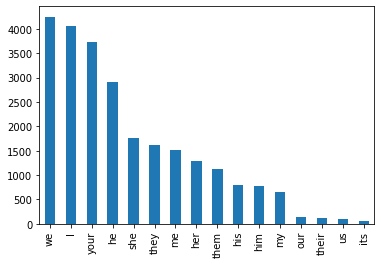

In [10]:
#'we' as most frequent pronoun. (All data excluded 'you' and 'it')
df['X'].value_counts().plot(kind = 'bar')

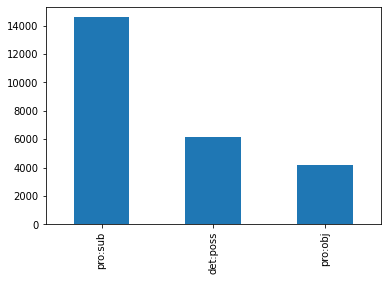

In [11]:
#Nominative case as most frequent case.
df['X_tag'].value_counts().plot(kind = 'bar')

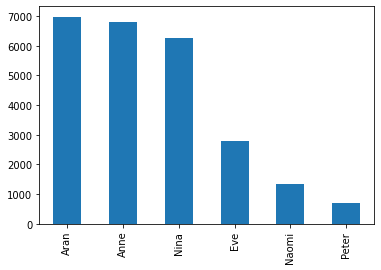

In [12]:
#Different parents have different amount of samples
df['name'].value_counts().plot(kind = 'bar')

In [13]:
#one-hot encoded aX, Xb and aXb
onehot_aX = pd.get_dummies(df.a)
onehot_Xb = pd.get_dummies(df.b)
onehot_aXb = pd.get_dummies(df.aXb)
df['onehot_aX'] = list(onehot_aX.values)
df['onehot_Xb'] = list(onehot_Xb.values)
df['onehot_aXb'] = list(onehot_aXb.values)

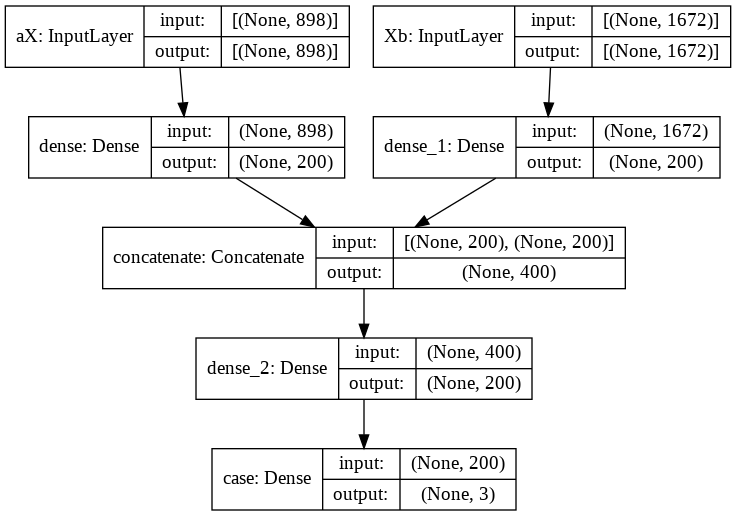

In [14]:
#Training model for aX + Xb (using aX + Xb information to predict the case of pronoun X)
aXshape = onehot_aX.shape[1]
bXshape = onehot_Xb.shape[1]
aX_input = keras.Input(shape=(aXshape,) , name ='aX')
Xb_input = keras.Input(shape=(bXshape,) ,name = 'Xb')
aX = layers.Dense(200, activation = 'relu')(aX_input)
Xb = layers.Dense(200, activation='relu')(Xb_input)
x = layers.concatenate([aX, Xb])
x = layers.Dense(200, activation = 'relu')(x)
case_pred = layers.Dense(3, name = 'case')(x)
model = keras.Model(
    inputs = [aX_input, Xb_input],
    outputs = case_pred)
keras.utils.plot_model(model, "aX + Xb model.png", show_shapes = True)


In [17]:
#preparing data
aX = np.asarray(onehot_aX).astype(np.float32)
Xb = np.asarray(onehot_Xb).astype(np.float32)
aXb = np.asarray(onehot_aXb).astype(np.float32)
Y_case = np.asarray(df['encoded_case']).astype(np.float32)
X = {'aX': aX, 'Xb': Xb}

In [19]:
Y_pronoun = np.asarray(df['encoded_case']).astype(np.float32)

In [ ]:
#10fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle = False, random_state = 88)
early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
trainindex = []
testindex = []
for train_index, test_index in kfold.split(aX, Y_case):
  print("Train:", train_index, "Test:", test_index)
  trainindex.append(train_index)
  testindex.append(test_index)

In [ ]:
#train the model with 10 fold 
#save the accuracy score 
#save the predicted case for each fold
aX_Xb_y_pred_kfold = []
aX_Xb_cvscores = []
for train, test in zip(trainindex, testindex): 
  model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy', 'mse'])
  model.fit({"aX": aX[train], "Xb": Xb[train]}, 
            Y_case[train],
          validation_split = 0.2,
          callbacks=[early_stop, tfdocs.modeling.EpochDots()], 
          epochs=100,
          batch_size = 32)
  scores = model.evaluate({"aX": aX[test], "Xb": Xb[test]}, y={"case": Y_case[test]}, verbose=2)
  y_pred = model.predict([aX[test], Xb[test]])
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  aX_Xb_cvscores.append(scores[1] * 100)
  aX_Xb_y_pred_kfold.append(y_pred)

In [24]:
print('aX+Xb accuracy for each fold:{}'.format(aX_Xb_cvscores))
print('aX+Xb accuracy average:{}'.format(sum(aX_Xb_cvscores)/len(aX_Xb_cvscores)))

aX+Xb accuracy for each fold:[97.38851189613342, 99.19646382331848, 99.19646382331848, 99.27681684494019, 99.47770237922668, 99.27681684494019, 98.99557828903198, 99.4375228881836, 97.06709384918213, 96.46302461624146]
aX+Xb accuracy average:98.57759952545166


In [ ]:
## Put the results in a dataframe
dftestsum = []
for i in range(0,10):
  dftest = df.iloc[testindex[i]]
  dftest['pred_y_aX_Xb'] = aX_Xb_y_pred_case[i]
  dftest['fold'] = i
  dftestsum.append(dftest)
kfold = pd.concat(dftestsum)
kfold['aX_Xb_correct'] = np.where((kfold['pred_y_aX_Xb'] == kfold['encoded_case']) , 1, 0)

In [31]:
from sklearn import metrics
target_names = ['det:poss','pro:obj','pro:sub']
print('aX+Xb classification')
print(metrics.classification_report(kfold['encoded_case'], kfold['pred_y_aX_Xb'], digits=3, target_names=target_names))

aX+Xb classification
              precision    recall  f1-score   support

    det:poss      0.983     0.969     0.976      6156
     pro:obj      0.965     0.973     0.969      4152
     pro:sub      0.993     0.996     0.995     14581

    accuracy                          0.986     24889
   macro avg      0.980     0.980     0.980     24889
weighted avg      0.986     0.986     0.986     24889

